In [1]:
import numpy as np
import pandas as pd
import math

from sklearn import datasets
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# Support Vector Machines

## Theory

The main idea behind SVM is that our labeled data might be embedded in a vector space such that each cluster with different labels are separable via a hyperplane.

In this setup, the data we have is a set of pairs $(x^{(i)},y^{(i)})$ where $x^{(i)}\in\mathbb{R}^n$ and $y^{(i)}=
\pm 1$ for every index $i=1,\ldots,N$.

Below, I will sample a random collection of points from $\mathbb{R}^2$ separable by many different hyperplanes.

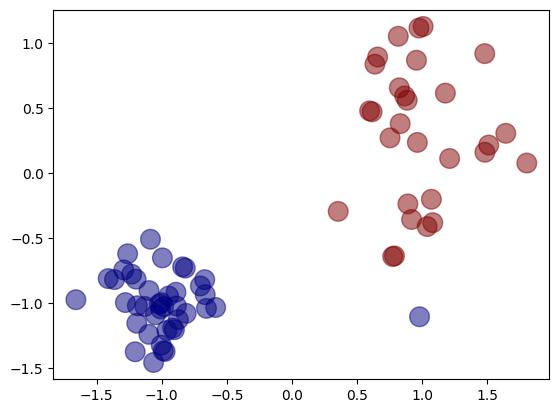

In [25]:
def randDisk(center,r,N):
    result = []
    x0,y0=center
    for i in range(N):
        r0 = np.random.normal(loc=r,scale=r/2)
        theta = np.random.uniform(0, 2*math.pi)
        result.append([x0+r0*math.cos(theta),y0+r0*math.sin(theta)])
    return result

tmp = randDisk([1,1],0.3,10)
tmp.extend(randDisk([-1,-1],0.3,40))
tmp.extend(randDisk([1,0],0.5,20))
cloud = np.array(tmp)
v = [1,1]
colors = [1 if np.dot(x,v)>0 else -1 for x in cloud]
data = pd.DataFrame({"x": cloud[:,0], "y": cloud[:,1], "class": colors})

plt.scatter(data['x'],data['y'],s=200,c=data['class'],alpha=0.5,cmap='jet')

Now, look at the picture above. We need a vector $v$ such that the gap between the separating hyperplanes is the largest. Below, the code tries random vectors for the normals of the separating hyperplanes. The correct method is doing a gradient descent algorithm that maximizes the gap that I outlined in the previous lecture.

We need a separating hyperplane given by a pair $(w,b)$ where $w\in\mathbb{R}^n$ and $b\in \mathbb{R}$ such that

$y^{(i)}(x^{(i)}\cdot w - b)\geq 1$ for every $i=1,\ldots,N$

If this condition is satisfied then the gap between the separating hyperplanes becomes $\frac{2}{\|w\|}$. Thus maximizing the gap becomes equivalent to finding a suitable vector $w$ with the smallest norm.

In [26]:
def findBeta(v,xs,side):
    d = np.array([v[1],-v[0]])
    tmp = [np.dot(x,v) for x in xs]
    if side == -1:
        i = np.argmin(tmp)
    else:
        i = np.argmax(tmp)
    return [xs[i],xs[i]+d]

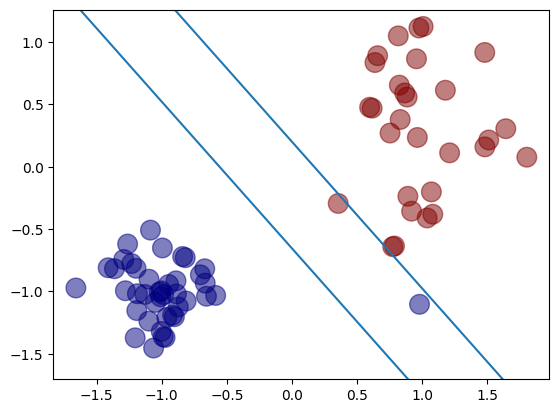

In [27]:
model = SVC(kernel="linear")

model.fit(data[["x","y"]],data["class"])

v = model.coef_[0]
a,b = findBeta(v,xs,-1)
c,d = findBeta(v,ys,1)
plt.scatter(data["x"],data["y"],c=data["class"],cmap='jet',s=200,alpha=0.5)
plt.axline(a,b)
plt.axline(c,d)

## Hard Margin vs Soft Margin

The standard SVM model operates on the assumption that the data is separable. This situation is described by having a **hard margin**.

In cases where the data is not completely separable, we might allow some mixing within the margin. In these cases, we use a **soft margin**

/tmp/ipykernel_153042/4002888549.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame({"x": new[:,0], "y": new[:,1], "class": cnew}))


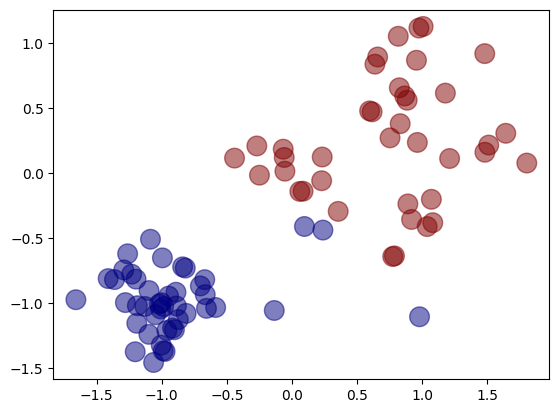

In [28]:
N1 = 10
N2 = 3

cnew = list([1]*N1 + [-1]*N2)

new = randDisk([0.0,0.0],0.2,N1)
new.extend(randDisk([-0.1,-0.5],0.4,N2))
new = np.array(new)

data = data.append(pd.DataFrame({"x": new[:,0], "y": new[:,1], "class": cnew}))
cloud = np.array(data)

plt.scatter(data.x,data.y,c=data["class"],cmap='jet',s=200,alpha=0.5)

In these cases instead of minimizing $\|w\|$ subject to 

$ 1 \leq y^{(i)}(x^{(i)}\cdot w - b) $ for all $i=1,\ldots,N$ 

we minimize the **total hinge loss function**
$$ \lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b)) $$
where $\lambda$ is a small positive regularization parameter. Changing $\lambda$ controls the degree of mixing of classes inside the margin.  Below, we set $\lambda = 1.0$ by setting `C=1.0`.

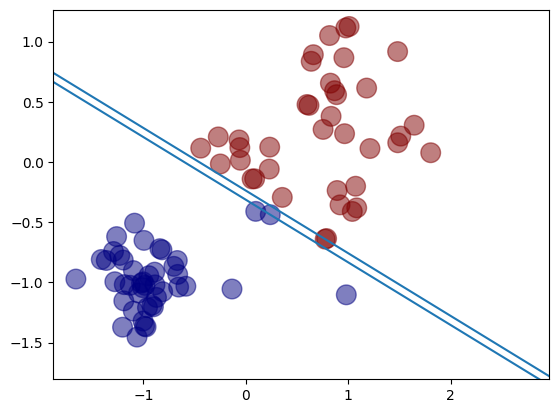

In [29]:
xs = np.array(data[["x","y"]][data["class"]==1])
ys = np.array(data[["x","y"]][data["class"]==-1])

model = SVC(kernel="linear",C=1.0)
model.fit(data[["x","y"]],data["class"])

v = model.coef_[0]
a,b = findBeta(v,xs,-1)
c,d = findBeta(v,ys,1)
plt.scatter(data.x,data.y,c=data["class"],cmap='jet',s=200,alpha=0.5)
plt.axline(a,b)
plt.axline(c,d)

## The Kernel Trick

There is another parameter that we can play with. That is the inner product we work with. 

Recall that our method heavily relies on the inner product since we either minimize $\|w\|$ subject to 

$y^{(i)}(x^{(i)}\cdot w - b) \geq 0 $

or minimizing the total hinge loss function

$\lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b))$

We can also use different inner products other than the ordinary Euclidean one:

$x\cdot y = \sum_i x_i y_i$

This method is equivalent to embedding $\mathbb{R}^n$ into another larger $\mathbb{R}^m$ via a (non)linear embedding and then using the ambient Euclidean product in $\mathbb{R}^m$.  This is useful when the original dataset is not linearly separable.

There are three main classes of kernels you can use

* linear
* polynomial
* radial basis function (RBF)

You can read the documentation [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html).

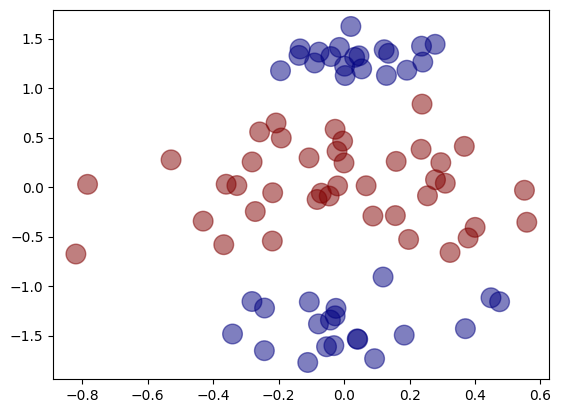

In [30]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.3],0.3,20))
cloud = np.array(tmp)

colors = [1]*40 + [-1]*40

data = pd.DataFrame({"x" : cloud[:,0], "y": cloud[:,1], "class": colors})
plt.scatter(data["x"],data["y"],c=data["class"],cmap='jet',s=200,alpha=0.5)

In [31]:
model = SVC(kernel="rbf",C=1.0,degree=2)
model.fit(data[["x","y"]],data["class"])

model.score(data[["x","y"]],data["class"])

1.0

## Multiclass SVM

Above we worked with SVM with binary classification. However, SVM is versatile enough to work with multiclass classification problems.

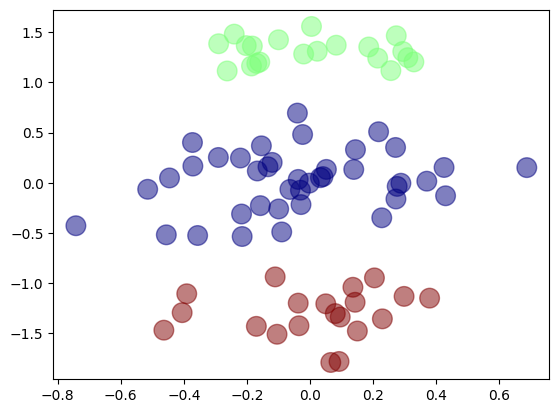

In [33]:
tmp = randDisk([0,0],0.4,40)
tmp.extend(randDisk([0,1.3],0.2,20))
tmp.extend(randDisk([0,-1.3],0.3,20))
cloud = np.array(tmp)

colors = [1]*40 + [2]*20 + [3]*20

data = pd.DataFrame({"x" : cloud[:,0], "y": cloud[:,1], "class": colors})
plt.scatter(data["x"],data["y"],c=data["class"],cmap='jet',s=200,alpha=0.5)

In [34]:
model = SVC(kernel="linear")
model.fit(data[["x","y"]],data["class"])

model.score(data[["x","y"]],data["class"])

1.0